In [3]:
%matplotlib ipympl
import glob
import pandas as pd
import numpy as np
import scipy
import librosa


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import identification.dataset

In [26]:
config = {
    "frame_size": 2048,
    "hop_ratio": 4,
    "n_coeff": 40,
    "sr": 16000,
    "sample_duration": 60,
    "feature": "LTAS_welch_db",
}


data = pd.read_pickle("/home/hugo/Thèse/identification/data/processed/dataset_cnsm.pkl")
data = data[(data.violin.isin(["A", "B", "C"]))]
data = data[data.session.isin([1, 3])]
data = data[data.extract == "gamme"]
data.violin = data.violin.map({"A": "Klimke", "B": "Levaggi", "C": "Stoppani"})

features = identification.dataset.get_dataset(config, data)

100%|██████████| 155/155 [00:06<00:00, 25.06it/s]

           start          end    violin    condition extract  \
0    1197.035102  1248.304762   Levaggi      aveugle   gamme   
1    1462.657514  1500.923999  Stoppani      aveugle   gamme   
2    1713.818413  1752.642177    Klimke      aveugle   gamme   
3    2714.505578  2751.285986  Stoppani  non-aveugle   gamme   
4    2943.732971  2979.956100    Klimke  non-aveugle   gamme   
..           ...          ...       ...          ...     ...   
150  1409.286603  1442.294410  Stoppani  non-aveugle   gamme   
151  1675.081536  1697.587002    Klimke  non-aveugle   gamme   
152  2583.589968  2605.693058  Stoppani      aveugle   gamme   
153  2788.431110  2806.066756    Klimke      aveugle   gamme   
154  2986.901119  3003.334387   Levaggi      aveugle   gamme   

                                                  file player  session  \
0    /home/hugo/Thèse/Data/CNSM/Session 1/Enregistr...   Paul        1   
1    /home/hugo/Thèse/Data/CNSM/Session 1/Enregistr...   Paul        1   
2    /hom

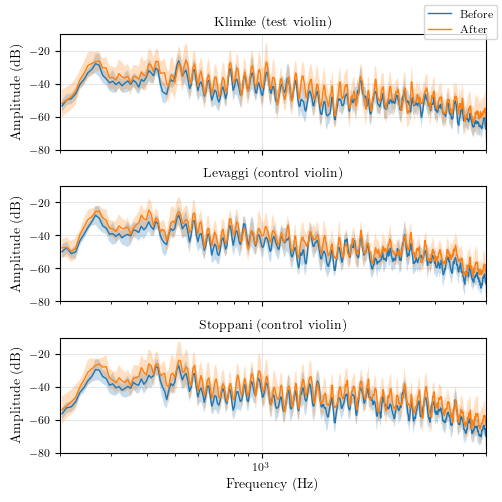

In [28]:
def std(group):
    group = np.vstack(group)
    std = np.std(group, axis=0)
    return std


f = np.arange(len(features.features[0])) / len(features.features[0]) * config["sr"] / 2
# f = np.arange(len(features.features[0]))
# Plot only between f1 and f2
mask = (f > 200) & (f < 6000)
# mask = f > 0

color = {"Klimke": "blue", "Levaggi": "orange", "Stoppani": "green"}


mpl.style.use("/home/hugo/Thèse/common/styles.mplstyle")
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 5))
stats = features.groupby(["violin", "session"])["features"].agg(["mean", std])

for i, row in stats.iterrows():
    violin, session = row.name
    ax = list(color.keys()).index(violin)
    smd_row = features.query(
        f"player == 'SMD' & violin == '{violin}' & session == {session}"
    ).iloc[0]

    axs[ax].plot(
        f[mask], row["mean"][mask], color="C0" if session == 1 else "C1", linewidth=1
    )
    axs[ax].fill_between(
        f[mask],
        row["mean"][mask] + row["std"][mask],
        row["mean"][mask] - row["std"][mask],
        alpha=0.25,
        # color=color[violin],
        label="_nolegend_",
    )

    # axs[ax].plot(f[mask], smd_row["features"][mask], linewidth=0.5)

    axs[ax].set_title(
        f"{violin}{" (test violin)" if violin == "Klimke" else " (control violin)"}"
    )
    axs[ax].set_xscale("log")
    axs[ax].set_xlim([200, 6000])
    axs[ax].set_ylim([-80, -10])
    axs[ax].set_ylabel("Amplitude (dB)")
    axs[ax].grid(True)

axs[-1].set_xlabel("Frequency (Hz)")
fig.legend(("Before", "After"))
# fig.suptitle("Admittances before and after the opening phase for each violin")
fig.savefig("../reports/figures/ltas.png")

In [4]:
for violin in ["Klimke", "Levaggi", "Stoppani"]:
    print(violin)
    s1 = stats.loc[(violin, 1)]["mean"][mask]
    s2 = stats.loc[(violin, 2)]["mean"][mask]
    s3 = stats.loc[(violin, 3)]["mean"][mask]
    print(np.linalg.norm(s1 - s2))
    print(np.linalg.norm(s1 - s3))

Klimke


KeyError: 2